# Анализ потребления алкоголя школьниками

Анализ данных из датасета [Student Alcohol Consumption](https://www.kaggle.com/datasets/uciml/student-alcohol-consumption). Цель анализа — понять факторы, влияющие на потребление алкоголя студентами, сегментировать студентов и построить модели для прогнозирования уровня потребления алкоголя.

## Содержание

1. [Импорт необходимых библиотек](#1-Импорт-необходимых-библиотек)
2. [Загрузка и обзор данных](#2-Загрузка-и-обзор-данных)
3. [Предварительный анализ данных (EDA)](#3-Предварительный-анализ-данных-EDA)
4. [Обработка данных и инженерия признаков](#4-Обработка-данных-и-инженерия-признаков)
5. [Построение моделей машинного обучения](#5-Построение-моделей-машинного-обучения)
    - [5.1. Классификация](#51-Классификация)
    - [5.2. Кластеризация](#52-Кластеризация)
    - [5.3. Ассоциативные правила](#53-Ассоциативные-правила)
6. [Выводы и рекомендации](#6-Выводы-и-рекомендации)


In [529]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.filterwarnings('ignore')

Датасет содержит две части: `student-mat.csv` и `student-por.csv`, соответствующие студентам, изучающим математику и португальский язык соответственно. Мы объединим эти два набора данных для более полного анализа.

In [530]:
mat_data = pd.read_csv('student-mat.csv')
por_data = pd.read_csv('student-por.csv')

print(f"Размер математики: {mat_data.shape}")
print(f"Размер португальского: {por_data.shape}")

Размер математики: (395, 33)
Размер португальского: (649, 33)


In [531]:
# Объединение данных
# Определим общие столбцы для объединения
common_columns = list(set(mat_data.columns).intersection(set(por_data.columns)))

# Объединяем по общим столбцам
data = pd.concat([mat_data[common_columns], por_data[common_columns]], axis=0, ignore_index=True)
print(f"Объединенный размер данных: {data.shape}")

Объединенный размер данных: (1044, 33)


In [532]:
data.head()

,internet,guardian,address,schoolsup,Mjob,G3,activities,higher,reason,Medu,...,absences,romantic,sex,nursery,goout,Pstatus,G2,famrel,Walc,Dalc
0,no,mother,U,yes,at_home,6,no,yes,course,4,...,6,no,F,yes,4,A,6,4,1,1
1,yes,father,U,no,at_home,6,no,yes,course,1,...,4,no,F,no,3,T,5,5,1,1
2,yes,mother,U,yes,at_home,10,no,yes,other,1,...,10,no,F,yes,2,T,8,4,3,2
3,yes,mother,U,no,health,15,yes,yes,home,4,...,2,yes,F,yes,2,T,14,3,1,1
4,no,father,U,no,other,10,no,yes,home,3,...,4,no,F,yes,2,T,10,4,2,1


In [533]:
# Проверка на наличие пропущенных значений
data.isnull().sum()

internet      0
guardian      0
address       0
schoolsup     0
Mjob          0
G3            0
activities    0
higher        0
reason        0
Medu          0
health        0
paid          0
traveltime    0
Fedu          0
failures      0
G1            0
age           0
school        0
Fjob          0
freetime      0
famsize       0
studytime     0
famsup        0
absences      0
romantic      0
sex           0
nursery       0
goout         0
Pstatus       0
G2            0
famrel        0
Walc          0
Dalc          0
dtype: int64

Предварительный анализ данных (EDA)

В данном разделе мы исследуем распределение признаков, их взаимосвязи и основные статистические характеристики.

In [534]:
# Основные статистические характеристики
data.describe()

,G3,Medu,health,traveltime,Fedu,failures,G1,age,freetime,studytime,absences,goout,G2,famrel,Walc,Dalc
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,11.341954,2.603448,3.543103,1.522989,2.387931,0.264368,11.213602,16.726054,3.201149,1.970307,4.434866,3.156130,11.246169,3.935824,2.284483,1.494253
std,3.864796,1.124907,1.424703,0.731727,1.099938,0.656142,2.983394,1.239975,1.031507,0.834353,6.210017,1.152575,3.285071,0.933401,1.285105,0.911714
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,15.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,10.000000,2.000000,3.000000,1.000000,1.000000,0.000000,9.000000,16.000000,3.000000,1.000000,0.000000,2.000000,9.000000,4.000000,1.000000,1.000000
50%,11.000000,3.000000,4.000000,1.000000,2.000000,0.000000,11.000000,17.000000,3.000000,2.000000,2.000000,3.000000,11.000000,4.000000,2.000000,1.000000
75%,14.000000,4.000000,5.000000,2.000000,3.000000,0.000000,13.000000,18.000000,4.000000,2.000000,6.000000,4.000000,13.000000,5.000000,3.000000,2.000000
max,20.000000,4.000000,5.000000,4.000000,4.000000,3.000000,19.000000,22.000000,5.000000,4.000000,75.000000,5.000000,19.000000,5.000000,5.000000,5.000000


<Figure size 1200x500 with 0 Axes>

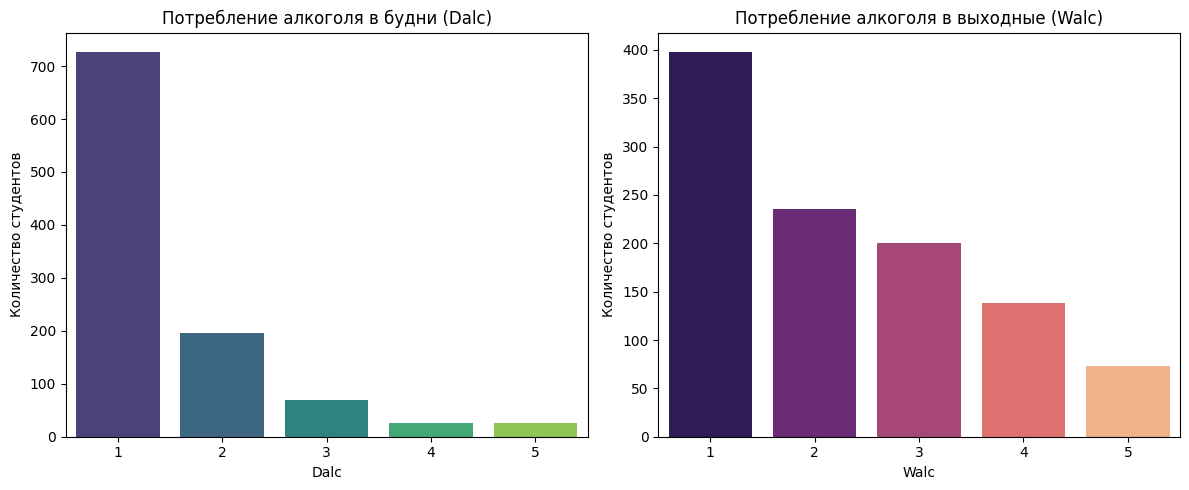

In [535]:
# Распределение потребления алкоголя (Dalc и Walc)
plt.figure(figsize=(12,5))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.countplot(x='Dalc', data=data, palette='viridis')
plt.title('Потребление алкоголя в будни (Dalc)')
plt.xlabel('Dalc')
plt.ylabel('Количество студентов')

plt.subplot(1,2,2)
sns.countplot(x='Walc', data=data, palette='magma')
plt.title('Потребление алкоголя в выходные (Walc)')
plt.xlabel('Walc')
plt.ylabel('Количество студентов')

plt.tight_layout()
plt.show()

In [536]:
# Кодирование категориальных признаков
categorical_columns = data.select_dtypes(include=['object']).columns
data_encoded_eda = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

corr = data_encoded_eda.corr()

In [537]:
def cor_with_threshold(corr_matrix, threshold):
    corr_no_diag = corr_matrix.copy()
    np.fill_diagonal(corr_no_diag.values, 0)
    high_corr_var = corr_no_diag.columns[(corr_no_diag.abs() > threshold).any()]
    filtered_corr = corr_matrix.loc[high_corr_var, high_corr_var]
    plt.figure(figsize=(20,15))
    sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, linecolor="black")
    plt.title(f"Корреляционная матрица (значения |corr| > {threshold})")
    plt.show()

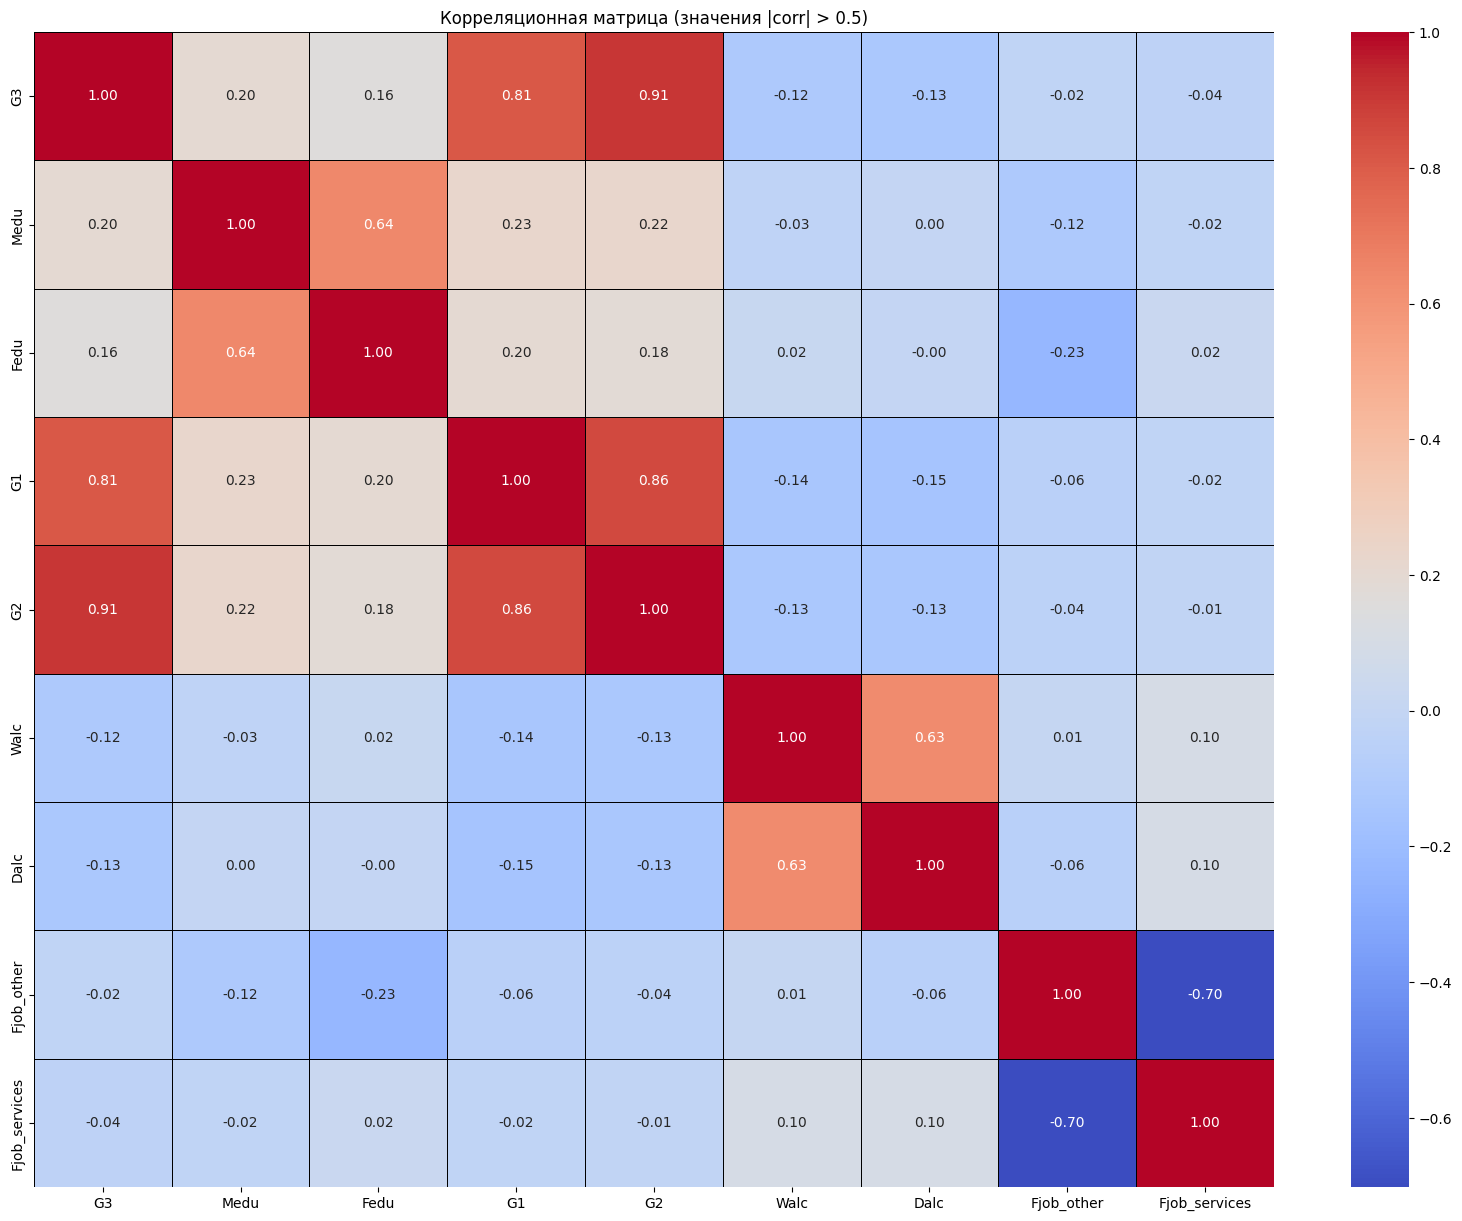

In [538]:
cor_with_threshold(corr, 0.5)

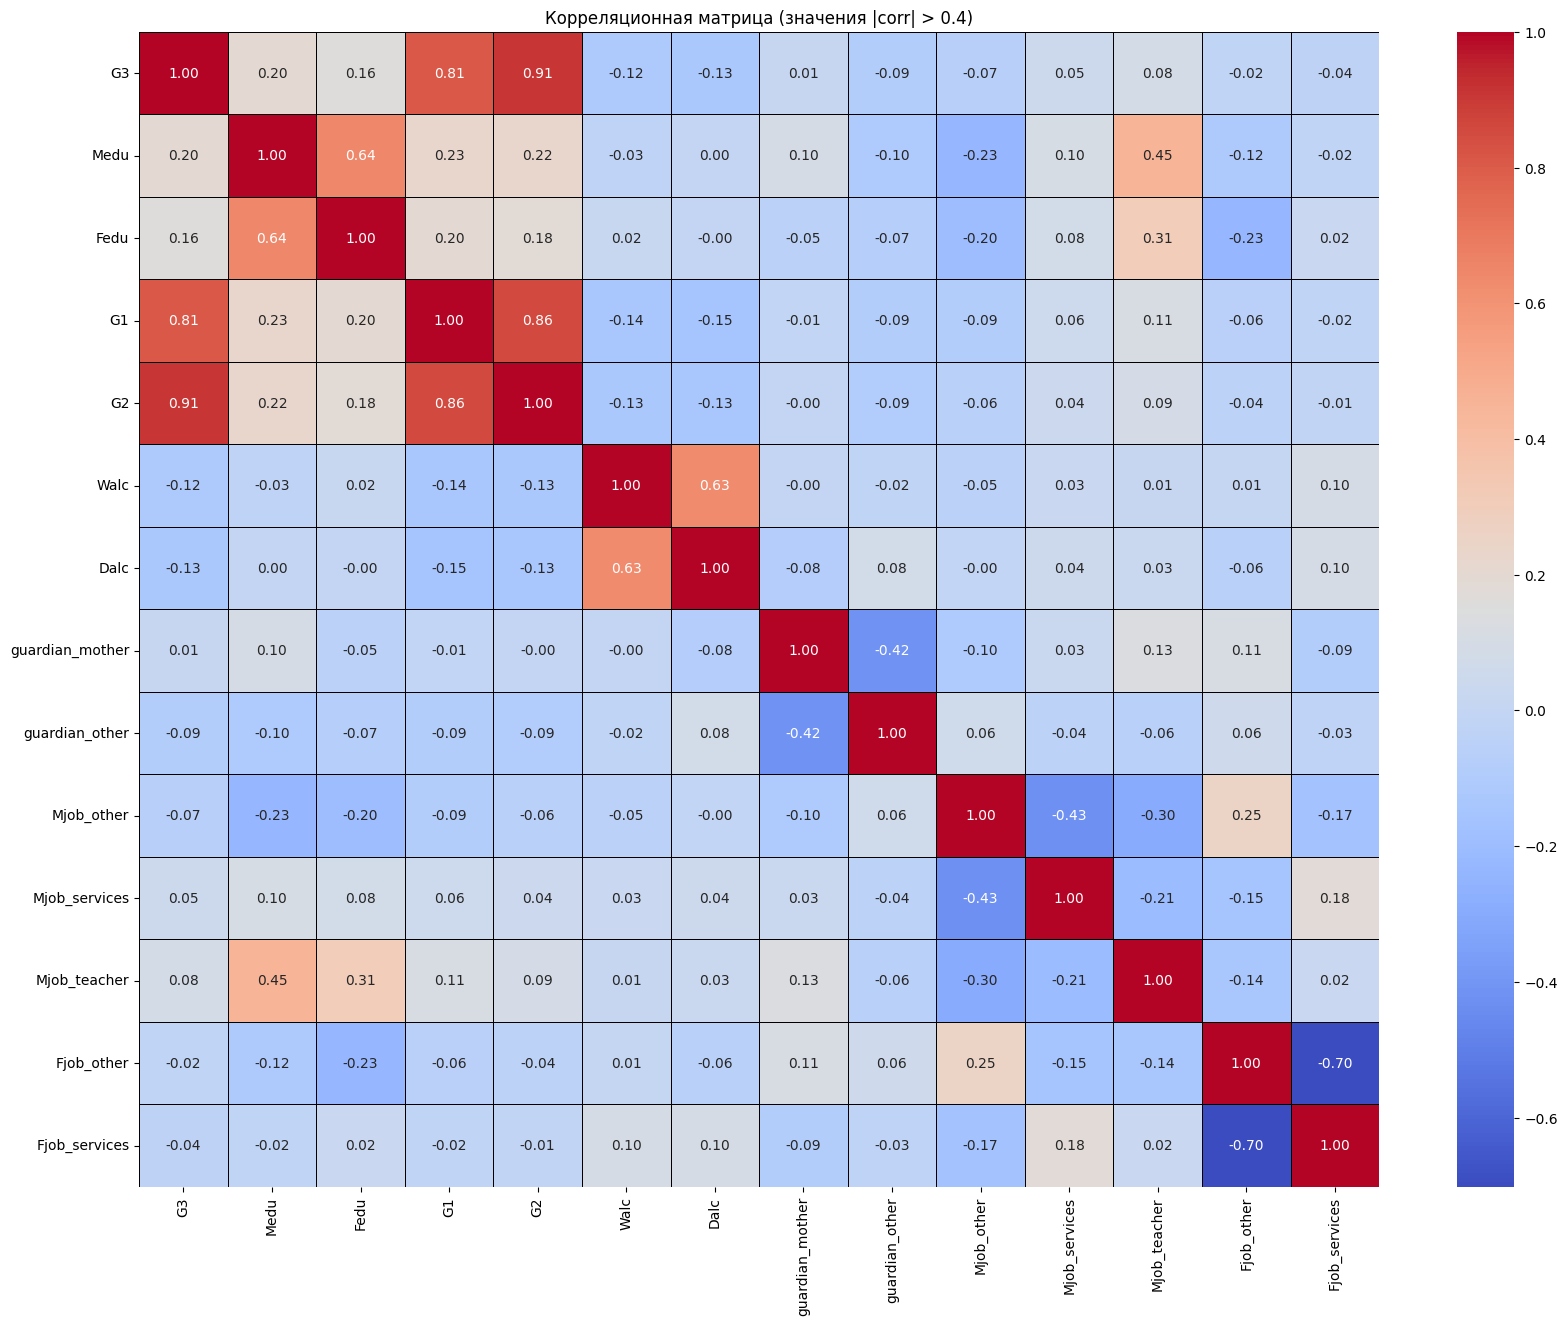

In [539]:
cor_with_threshold(corr, 0.4)

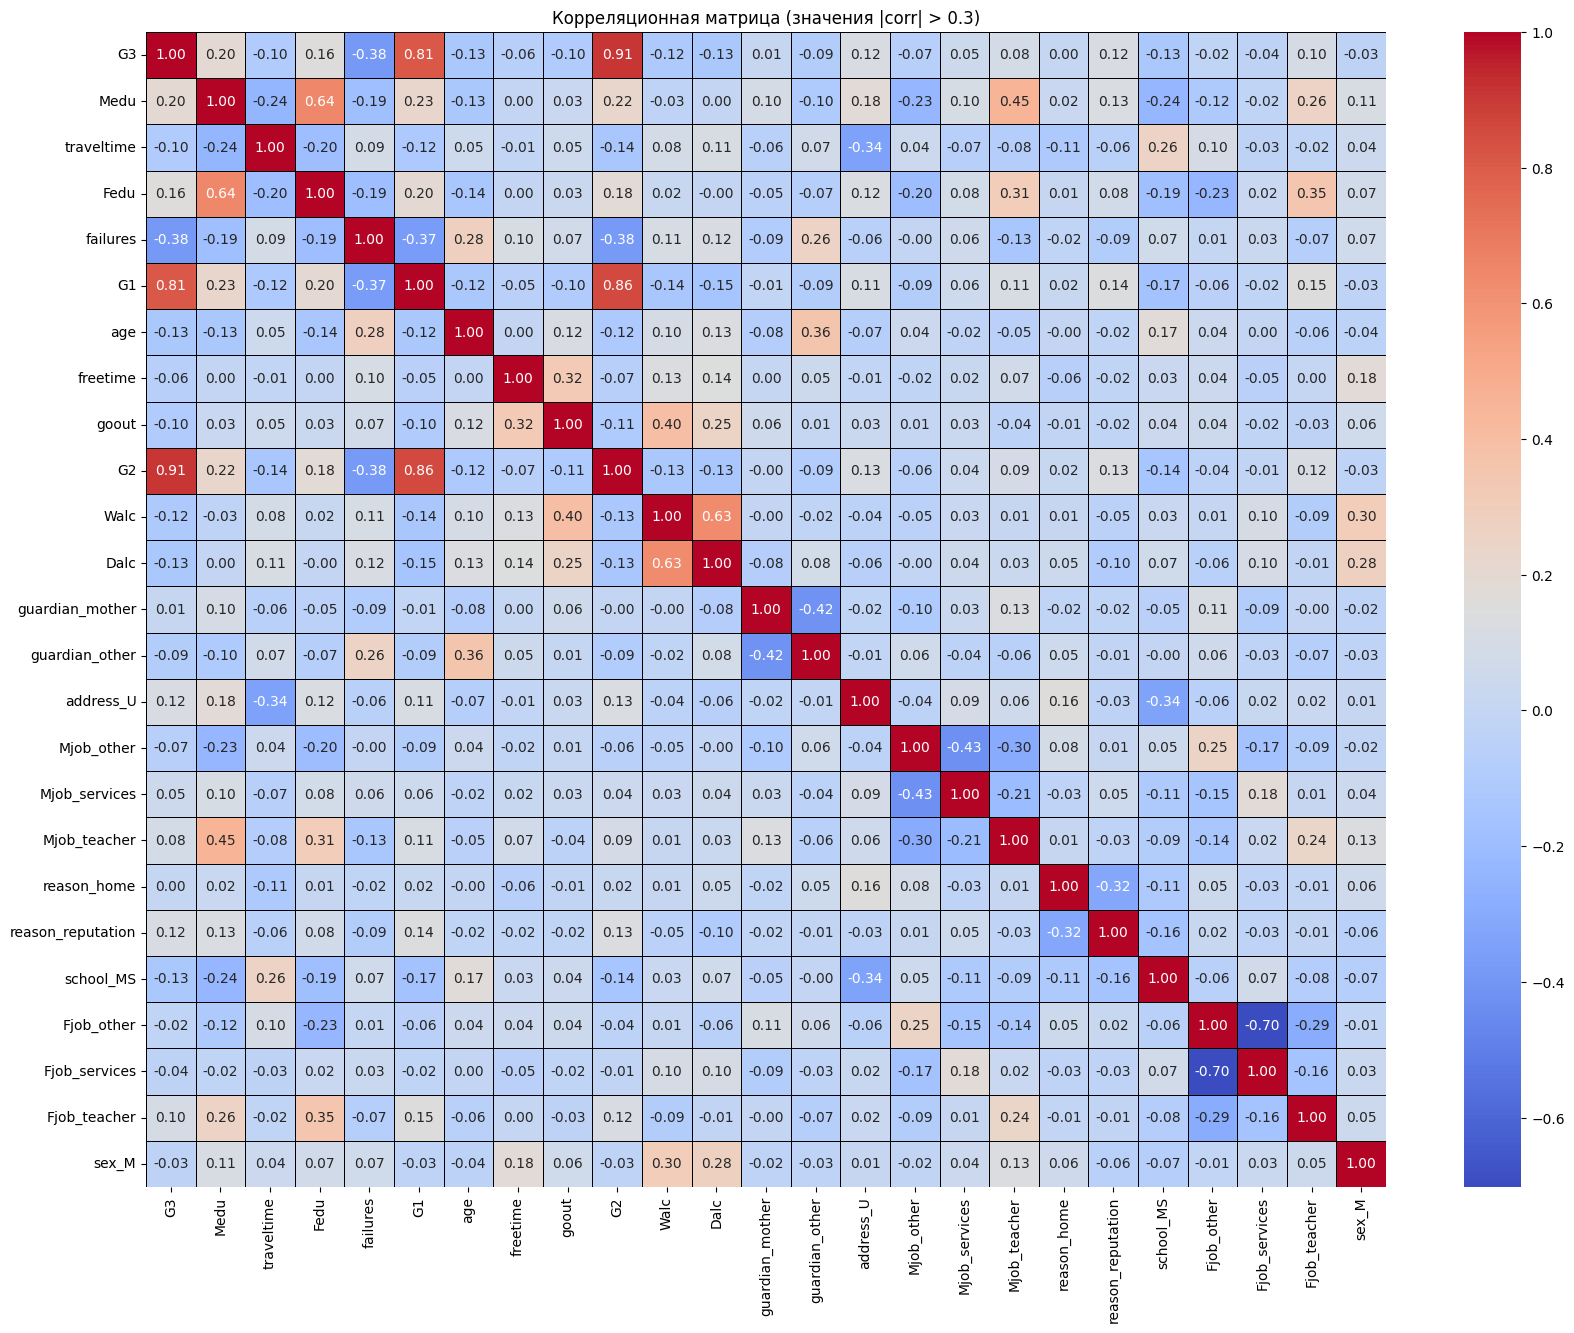

In [540]:
cor_with_threshold(corr, 0.3)

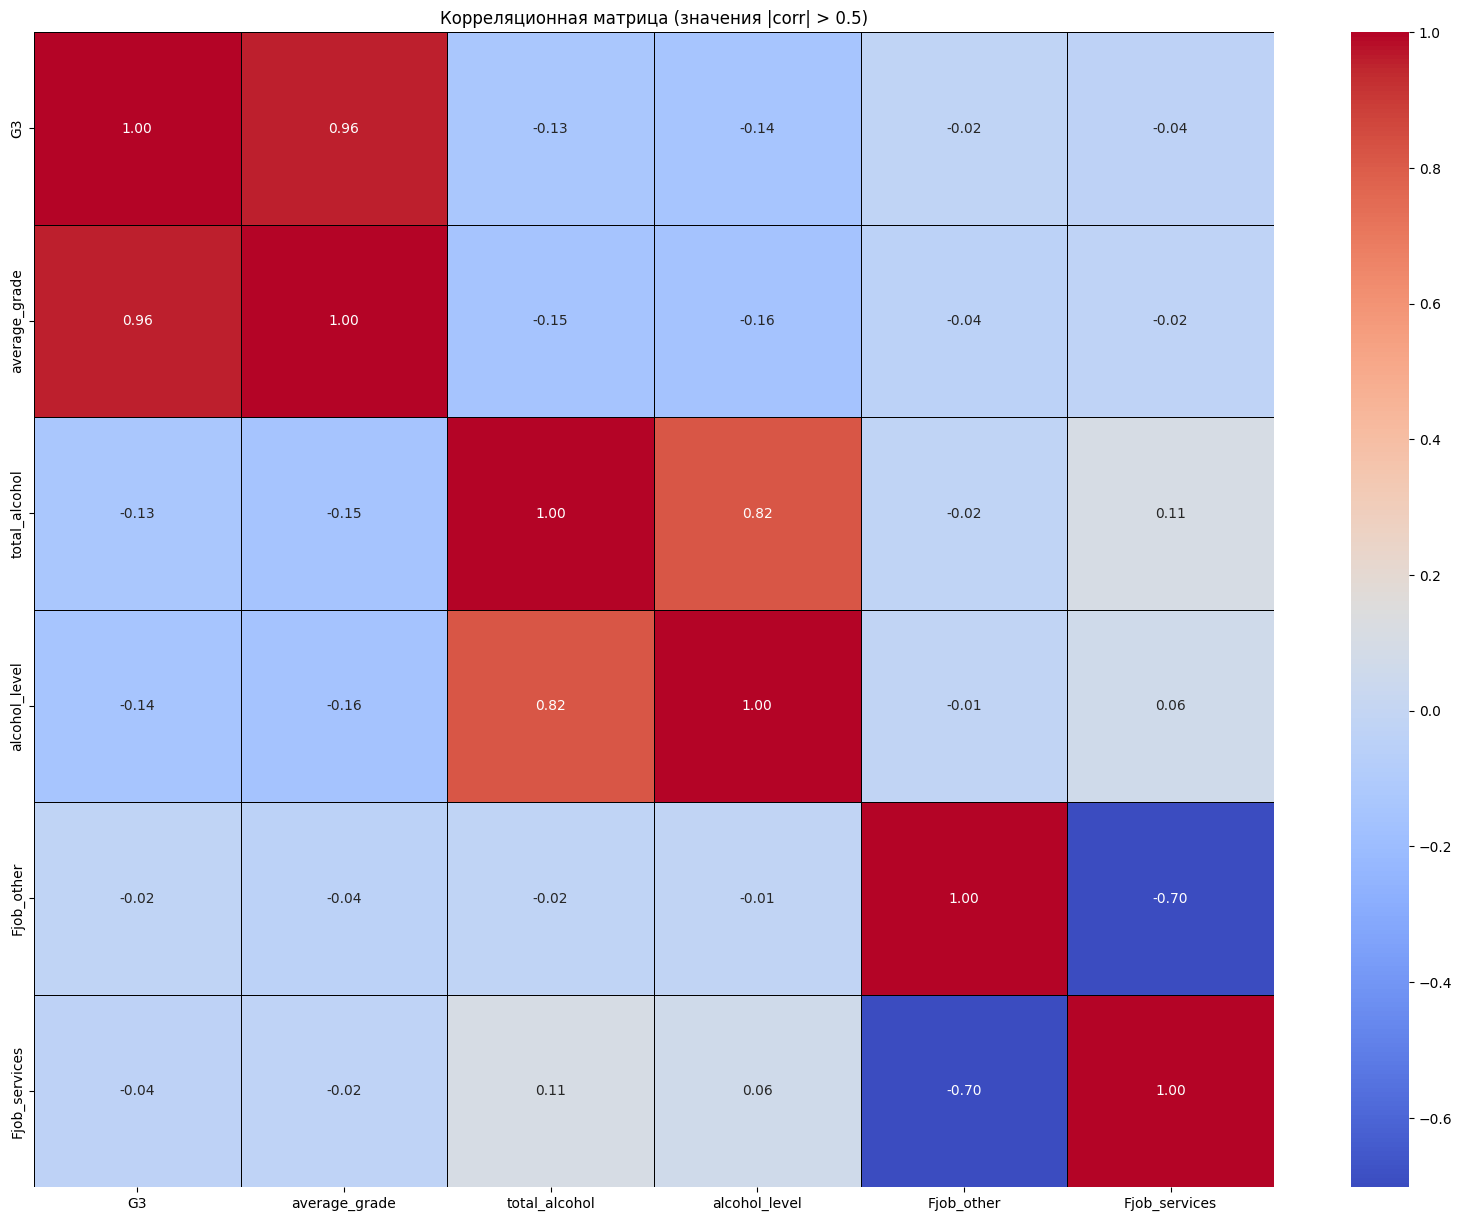

In [541]:
# Создание новых признаков
data['average_grade'] = data[['G1', 'G2', 'G3']].mean(axis=1)
data['total_alcohol'] = data['Dalc'] + data['Walc']
data['parent_education'] = data['Medu'] + data['Fedu']

# Определение целевой переменной
# Например, классификация на низкое и высокое потребление алкоголя
# Определим пороговое значение, например, total_alcohol > 5 как высокое потребление
data['alcohol_level'] = data['total_alcohol'].apply(lambda x: 1 if x > 5 else 0)

features = data.drop(['G1', 'G2', 'Dalc', 'Walc', 'Medu', 'Fedu'], axis=1)

features_encoded_eda = pd.get_dummies(features, columns=categorical_columns, drop_first=True)

corr = features_encoded_eda.corr()

cor_with_threshold(corr, 0.5)

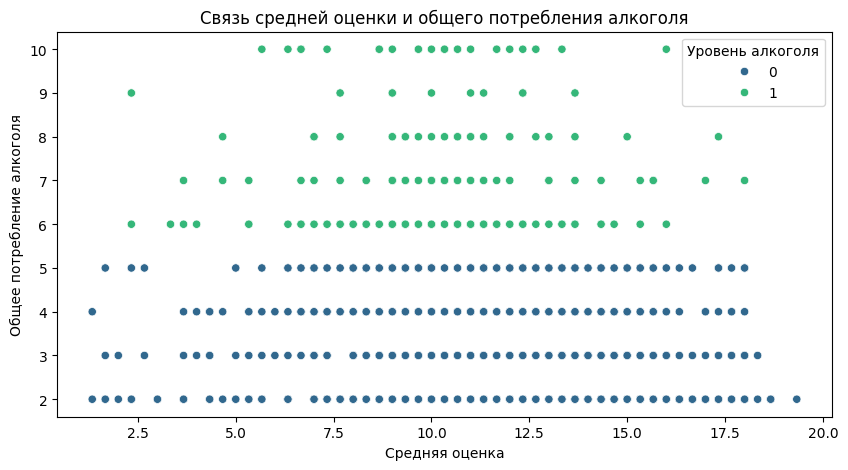

In [542]:
# Взаимосвязь потребления алкоголя с оценками

plt.figure(figsize=(10,5))
sns.scatterplot(x='average_grade', y='total_alcohol', data=data, hue='alcohol_level', palette='viridis')
plt.title('Связь средней оценки и общего потребления алкоголя')
plt.xlabel('Средняя оценка')
plt.ylabel('Общее потребление алкоголя')
plt.legend(title='Уровень алкоголя')
plt.show()

Переведя катигориальные признаки в бинарные и построив матрицу кореляции мы приходи к следющим выводам:
Общие закономерности:
* В школе  Mousinho da Silveira учаться люди старше
* Кто часто пьёт на недле, пьёт и в выходные
Закономерности относительно целевой метрики
* Успеваемость обратно пропоциональна "failures", однако из описания датасета не совсем понятно, что значит эта переменная(я перевёл это как пересдачи, но не понятно почему они начинаются с 1)
* Успеваемость в семестрах прямопорциональна оценке за экзамен

1. Сильная взаимосвязь между оценками студентов

    G3 (финальная оценка) и G1, G2 (оценки за первые два периода):
        Корреляция между G3 и G1: 0.81
        Корреляция между G3 и G2: 0.91
        Корреляция между G1 и G2: 0.86

    Вывод: Существует высокая положительная корреляция между финальной оценкой студентов (G3) и их оценками за первые два периода (G1 и G2). Это указывает на то, что успеваемость студентов в начале учебного года сильно влияет на их итоговые оценки. Студенты, показывающие хорошие результаты на ранних этапах обучения, вероятно, сохранят высокий уровень успеваемости до конца года.

2. Взаимосвязь уровня образования родителей

    Medu (образование матери) и Fedu (образование отца): 0.64

    Вывод: Значительная положительная корреляция между образованием матери и отца указывает на то, что родители студентов обычно имеют сопоставимый уровень образования. Это может свидетельствовать о том, что семейный фон играет важную роль в уровне образования, который достигают дети.

3. Связь дневного и вечернего потребления алкоголя

    Walc (вечернее потребление алкоголя) и Dalc (дневное потребление алкоголя): 0.63

    Вывод: Умеренная положительная корреляция между дневным и вечерним потреблением алкоголя указывает на то, что студенты, которые употребляют алкоголь в течение дня, склонны также употреблять его вечером. Это может свидетельствовать о регулярных привычках потребления алкоголя или о том, что учащиеся, склонные к употреблению алкоголя, делают это как в дневное, так и в вечернее время.

4. Отрицательная корреляция между типами занятости

    Fjob_other (занятость в других секторах) и Fjob_services (занятость в сфере услуг): -0.70

    Вывод: Сильная отрицательная корреляция между занятостью в других секторах и занятостью в сфере услуг указывает на то, что студенты, работающие в одном из этих секторов, редко одновременно работают в другом. Это может быть связано с тем, что различные сектора имеют разные требования и условия труда, что делает одновременную работу в обоих секторах маловероятной.

Общие наблюдения

    Низкая взаимосвязь большинства признаков: Большинство остальных корреляций в матрице ниже порога 0.3, что свидетельствует о слабых или отсутствующих прямых линейных связях между ними. Это может указывать на то, что уровень потребления алкоголя студентами зависит от множества факторов, и для его прогнозирования потребуется учитывать комплексные взаимодействия между признаками или использовать нелинейные модели.

    Отсутствие сильной корреляции между уровнем образования родителей и успеваемостью: Хотя образование родителей (Medu и Fedu) коррелирует с общим уровнем образования в семье, прямой сильной связи между образованием родителей и оценками студентов (G1, G2, G3) не наблюдается. Это может означать, что другие факторы, такие как личная мотивация, школьные условия или социальная среда, играют более значимую роль в успеваемости студентов.

In [543]:
# Выбор признаков
# Учитывая высокую корреляцию между G1, G2 и G3, а также между Dalc и Walc
# Оставим только G3 и Walc

# TODO: Нужно дропнуть коррелируемые признаки
features = data.drop(['G1', 'G2', 'G3', 'Dalc', 'Walc', 'average_grade', 'total_alcohol', 'alcohol_level'], axis=1)

# Добавляем 'G3' и 'Walc' обратно как ключевые признаки
features = features.copy()
# features['G3'] = data['G3']
# features['Walc'] = data['Walc']
features['average_grade'] = data['average_grade']
features['total_alcohol'] = data['total_alcohol']
# features['alcohol_level'] = data['alcohol_level']
features['parent_education'] = data['parent_education']

# Проверка формы данных
print(f"Количество признаков после выбора: {features.shape[1]}")
print(features.columns)

Количество признаков после выбора: 31
Index(['internet', 'guardian', 'address', 'schoolsup', 'Mjob', 'activities',
       'higher', 'reason', 'Medu', 'health', 'paid', 'traveltime', 'Fedu',
       'failures', 'age', 'school', 'Fjob', 'freetime', 'famsize', 'studytime',
       'famsup', 'absences', 'romantic', 'sex', 'nursery', 'goout', 'Pstatus',
       'famrel', 'parent_education', 'average_grade', 'total_alcohol'],
      dtype='object')


In [544]:
# Разделение признаков на категориальные и числовые
categorical_features = features.select_dtypes(include=['object']).columns
numerical_features = features.select_dtypes(include=['int64', 'float64']).columns

print(f"Категориальные признаки: {list(categorical_features)}")
print(f"Числовые признаки: {list(numerical_features)}")

Категориальные признаки: ['internet', 'guardian', 'address', 'schoolsup', 'Mjob', 'activities', 'higher', 'reason', 'paid', 'school', 'Fjob', 'famsize', 'famsup', 'romantic', 'sex', 'nursery', 'Pstatus']
Числовые признаки: ['Medu', 'health', 'traveltime', 'Fedu', 'failures', 'age', 'freetime', 'studytime', 'absences', 'goout', 'famrel', 'parent_education', 'average_grade', 'total_alcohol']


In [545]:
# Применение One-Hot Encoding к категориальным признакам
features_encoded = pd.get_dummies(features, columns=categorical_features, drop_first=True)

print(f"Размер после кодирования: {features_encoded.shape}")
features_encoded.head()

Размер после кодирования: (1044, 40)


,Medu,health,traveltime,Fedu,failures,age,freetime,studytime,absences,goout,...,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,famsize_LE3,famsup_yes,romantic_yes,sex_M,nursery_yes,Pstatus_T
0,4,3,2,4,0,18,3,2,6,4,...,False,False,False,True,False,False,False,False,True,False
1,1,3,1,1,0,17,3,2,4,3,...,False,True,False,False,False,True,False,False,False,True
2,1,3,1,1,3,15,3,2,10,2,...,False,True,False,False,True,False,False,False,True,True
3,4,5,1,2,0,15,2,3,2,2,...,False,False,True,False,False,True,True,False,True,True
4,3,5,1,3,0,16,3,2,4,2,...,False,True,False,False,False,True,False,False,True,True


In [546]:
# Масштабирование числовых признаков
scaler = StandardScaler()
features_encoded[numerical_features] = scaler.fit_transform(features_encoded[numerical_features])

# Проверка масштабирования
features_encoded.head()

,Medu,health,traveltime,Fedu,failures,age,freetime,studytime,absences,goout,...,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,famsize_LE3,famsup_yes,romantic_yes,sex_M,nursery_yes,Pstatus_T
0,1.242077,-0.381387,0.652210,1.466302,-0.403106,1.027889,-0.195099,0.035606,0.252155,0.732511,...,False,False,False,True,False,False,False,False,True,False
1,-1.426089,-0.381387,-0.715074,-1.262431,-0.403106,0.221035,-0.195099,0.035606,-0.070060,-0.135527,...,False,True,False,False,False,True,False,False,False,True
2,-1.426089,-0.381387,-0.715074,-1.262431,4.171268,-1.392674,-0.195099,0.035606,0.896584,-1.003566,...,False,True,False,False,True,False,False,False,True,True
3,1.242077,1.023086,-0.715074,-0.352853,-0.403106,-1.392674,-1.165019,1.234713,-0.392275,-1.003566,...,False,False,True,False,False,True,True,False,True,True
4,0.352689,1.023086,-0.715074,0.556724,-0.403106,-0.585820,-0.195099,0.035606,-0.070060,-1.003566,...,False,True,False,False,False,True,False,False,True,True


In [547]:
# Вычисление корреляции признаков с целевой переменной
corr_with_target = features_encoded.corr()['total_alcohol'].abs().sort_values(ascending=False)

# Выбор признаков с корреляцией > 0.1
selected_features = corr_with_target[corr_with_target > 0.1].index.tolist()

print("Признаки, выбранные на основе корреляции с целевой переменной:")
print(selected_features)

# Исключаем целевую переменную из списка признаков
selected_features.remove('total_alcohol')

# Фильтрация признаков
features_encoded_filtered = features_encoded[selected_features]

print(f"Количество признаков после фильтрации: {features_encoded_filtered.shape[1]}")

Признаки, выбранные на основе корреляции с целевой переменной:
['total_alcohol', 'goout', 'sex_M', 'studytime', 'average_grade', 'absences', 'freetime', 'age', 'failures', 'higher_yes', 'Fjob_services', 'reason_other', 'traveltime', 'famrel']
Количество признаков после фильтрации: 13


In [548]:
# Определение целевой переменной
target = data['total_alcohol']

# Разделение данных: 80% для обучения, 20% для тестирования
X_train, X_test, y_train, y_test = train_test_split(features_encoded_filtered, target, test_size=0.2, random_state=42, stratify=target)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (835, 13)
Размер тестовой выборки: (209, 13)


## Построение моделей МО

Классификация. Random Forest

In [549]:
# Инициализация модели Random Forest
rf = RandomForestClassifier(random_state=42)

# Гиперпараметры для Grid Search
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search с кросс-валидацией
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print(f"Лучшие параметры Random Forest: {grid_rf.best_params_}")

/home/sap/src/personal/ml-basics/course-work/.conda/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/sap/src/personal/ml-basics/course-work/.conda/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sap/src/personal/ml-basics/course-work/.conda/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sap/src/personal/ml-basics/course-work/.conda/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _sco

Лучшие параметры Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [550]:
# Оценка модели Random Forest на тестовой выборке
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Random Forest - Классификационный отчет:")
print(classification_report(y_test, y_pred_rf))

print(f"ROC-AUC: {roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]):.2f}")

Random Forest - Классификационный отчет:
              precision    recall  f1-score   support

           2       0.56      0.90      0.69        78
           3       0.74      0.39      0.51        36
           4       0.36      0.28      0.32        32
           5       0.50      0.38      0.43        24
           6       0.58      0.41      0.48        17
           7       1.00      0.70      0.82        10
           8       1.00      0.20      0.33         5
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         5

    accuracy                           0.56       209
   macro avg       0.53      0.36      0.40       209
weighted avg       0.57      0.56      0.53       209



ValueError: multi_class must be in ('ovo', 'ovr')

XGBoost

In [500]:
# Инициализация модели XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

# Гиперпараметры для Grid Search
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1]
}

# Grid Search с кросс-валидацией
grid_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print(f"Лучшие параметры XGBoost: {grid_xgb.best_params_}")

Лучшие параметры XGBoost: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.7}


In [501]:
# Оценка модели XGBoost на тестовой выборке
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("XGBoost - Классификационный отчет:")
print(classification_report(y_test, y_pred_xgb))

print(f"ROC-AUC: {roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:,1]):.2f}")

XGBoost - Классификационный отчет:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       170
           1       0.73      0.62      0.67        39

    accuracy                           0.89       209
   macro avg       0.82      0.78      0.80       209
weighted avg       0.88      0.89      0.88       209

ROC-AUC: 0.92


In [502]:
# Инициализация модели MLP
mlp = MLPClassifier(random_state=42, max_iter=1000, early_stopping=True, tol=1e-4)

# Гиперпараметры для Grid Search
param_grid_mlp = {
    'hidden_layer_sizes': [(100,), (100, 50), (50, 50, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant','adaptive'],
}

# Grid Search с кросс-валидацией
grid_mlp = GridSearchCV(estimator=mlp, param_grid=param_grid_mlp, cv=5, scoring='f1', n_jobs=-1)
grid_mlp.fit(X_train, y_train)

print(f"Лучшие параметры MLP: {grid_mlp.best_params_}")


Лучшие параметры MLP: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


In [503]:
# Оценка модели MLP на тестовой выборке
best_mlp = grid_mlp.best_estimator_
y_pred_mlp = best_mlp.predict(X_test)

print("MLP - Классификационный отчет:")
print(classification_report(y_test, y_pred_mlp))

print(f"ROC-AUC: {roc_auc_score(y_test, best_mlp.predict_proba(X_test)[:,1]):.2f}")


MLP - Классификационный отчет:
              precision    recall  f1-score   support

           0       0.84      0.95      0.90       170
           1       0.53      0.23      0.32        39

    accuracy                           0.82       209
   macro avg       0.69      0.59      0.61       209
weighted avg       0.79      0.82      0.79       209

ROC-AUC: 0.78


In [504]:
# Инициализация модели SVM
svm = SVC(random_state=42, probability=True)

# Гиперпараметры для Grid Search
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Grid Search с кросс-валидацией
grid_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train, y_train)

print(f"Лучшие параметры SVM: {grid_svm.best_params_}")


Лучшие параметры SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [505]:
# Оценка модели SVM на тестовой выборке
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)

print("SVM - Классификационный отчет:")
print(classification_report(y_test, y_pred_svm))

print(f"ROC-AUC: {roc_auc_score(y_test, best_svm.predict_proba(X_test)[:,1]):.2f}")


SVM - Классификационный отчет:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       170
           1       0.70      0.67      0.68        39

    accuracy                           0.89       209
   macro avg       0.81      0.80      0.81       209
weighted avg       0.88      0.89      0.88       209

ROC-AUC: 0.89


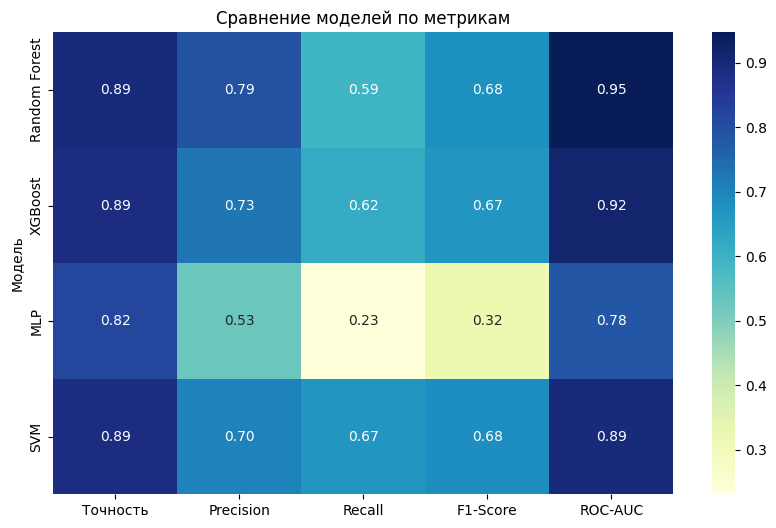

,Точность,Precision,Recall,F1-Score,ROC-AUC
Модель,,,,,
Random Forest,0.894737,0.793103,0.589744,0.676471,0.947436
XGBoost,0.885167,0.727273,0.615385,0.666667,0.916139
MLP,0.818182,0.529412,0.230769,0.321429,0.782353
SVM,0.885167,0.702703,0.666667,0.684211,0.894872


In [506]:
# Сравнение моделей по основным метрикам

models = ['Random Forest', 'XGBoost', 'MLP', 'SVM']
accuracy = [
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_xgb),
    accuracy_score(y_test, y_pred_mlp),
    accuracy_score(y_test, y_pred_svm)
]
precision = [
    precision_score(y_test, y_pred_rf),
    precision_score(y_test, y_pred_xgb),
    precision_score(y_test, y_pred_mlp),
    precision_score(y_test, y_pred_svm)
]
recall = [
    recall_score(y_test, y_pred_rf),
    recall_score(y_test, y_pred_xgb),
    recall_score(y_test, y_pred_mlp),
    recall_score(y_test, y_pred_svm)
]
f1 = [
    f1_score(y_test, y_pred_rf),
    f1_score(y_test, y_pred_xgb),
    f1_score(y_test, y_pred_mlp),
    f1_score(y_test, y_pred_svm)
]
roc_auc = [
    roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]),
    roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:,1]),
    roc_auc_score(y_test, best_mlp.predict_proba(X_test)[:,1]),
    roc_auc_score(y_test, best_svm.predict_proba(X_test)[:,1])
]

comparison_df = pd.DataFrame({
    'Модель': models,
    'Точность': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'ROC-AUC': roc_auc
})

# Отображение таблицы
plt.figure(figsize=(10,6))
sns.heatmap(comparison_df.set_index('Модель'), annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Сравнение моделей по метрикам')
plt.show()

# Печать таблицы
comparison_df.set_index('Модель')
